The goal of this benchmark is to offer a comparison between differents pre-trained image recognition's networks based on the [Imagenet](http://image-net.org/) dataset wich allows to work on naturals images for 1000 labels. Some image's transformations like grayscale or downsampling will be implemented to infer on their influence on the accuracy or the computation's time of the networks.    

On this notebook I used the [Pytorch](https://pytorch.org/) library for running the networks and the [pandas](https://pandas.pydata.org/docs/getting_started/index.html) library to collect and display the results. This Notebook was done during a master 1 internship by [Jean-Nicolas Jérémie](https://github.com/JNJER) under the supervision of [Laurent PERRINET](https://laurentperrinet.github.io/), researcher at the Neurosciences Institute of Timone (INT).

<!-- TEASER_END -->


# Initialization of the benchmark

## Importing librarys and definition of dataset:

In [1]:
%matplotlib inline
%mkdir -p DCNN_benchmark

In [2]:
%%writefile DCNN_benchmark/init.py

# import libs
import os
import time 
from time import strftime,gmtime
import json
import time 
import numpy as np
import imageio
from numpy import random
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# to store results
import pandas as pd

# figure's variables
fig_width = 20
phi = (np.sqrt(5)+1)/2
phi = phi**2
colors = ['b', 'r', 'k','g']

# host & date's variables 
HOST = os.uname()[1]
#datetag = strftime("%Y-%m-%d", gmtime()) 
datetag = '2020-08-27'

#dataset configuration

image_size = 256 # default image resolution
image_sizes = 2**np.arange(6, 10) # resolutions explored

N_images_per_class = 10
#i_labels = random.randint(1000, size=(N_labels)) # Random choice
i_labels = [409, 530, 892, 487, 920, 704, 879, 963, 646, 620 ] # Pre-selected classes
N_labels = len(i_labels)

id_dl = ''
root = 'data'
folder = 'imagenet_classes_100'
path = os.path.join(root, folder) # data path

with open('ImageNet-Datasets-Downloader/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
labels[0].split(', ')
labels = [label.split(', ')[1].lower().replace('_', ' ') for label in labels]

class_loader = 'ImageNet-Datasets-Downloader/imagenet_class_info.json'
with open(class_loader, 'r') as fp: # get all the classes on the data_downloader
    name = json.load(fp)

# a reverse look-up-table giving the index of a given label (within the whole set of imagenet labels)
reverse_labels = {}
for i_label, label in enumerate(labels):
    reverse_labels[label] = i_label
# a reverse look-up-table giving the index of a given i_label (within the sub-set of classes)
reverse_i_labels = {}
for i_label, label in enumerate(i_labels):
    reverse_i_labels[label] = i_label

print('-'*24)
# choosing the selected classes for recognition
for i_label in i_labels: 
    print('label', i_label, '=', labels[i_label])
    for key in name:
        if name[key]['class_name'] == labels[i_label]:
            id_dl += key + ' '
print('label IDs = ', id_dl)

Overwriting DCNN_benchmark/init.py


In [3]:
%run DCNN_benchmark/init.py

------------------------
label 409 = analog clock
label 530 = digital clock
label 892 = wall clock
label 487 = cellular telephone
label 920 = traffic light
label 704 = parking meter
label 879 = umbrella
label 963 = pizza
label 646 = maze
label 620 = laptop
label IDs =  n02708093 n03196217 n04548280 n02992529 n06874185 n03891332 n04507155 n07873807 n03733281 n03642806 


In [4]:
if HOST == 'fortytwo':
    do_local = False 
    python_exec = "KMP_DUPLICATE_LIB_OK=TRUE python3"
else :
    do_local =True

## Download of example images from ImageNet :

We use an [ImageNet dataloader](https://github.com/laurentperrinet/ImageNet-datasets-downloader) to populate a dataset based on the pre-selected or randoms classes listed in the `DCNN_benchmark/init.py` file.

In [5]:
scriptname = 'DCNN_benchmark/dataset.py'

In [6]:
%%writefile {scriptname}

from DCNN_benchmark.init import *

# check if the folder exist
if os.path.isdir(path):
    list_dir = os.listdir(path)
    print("The folder " , folder, " already exists, it includes: ", list_dir)
    
# no folder, creating one 
else :
    print(f"No existing path match for this folder, creating a folder at {path}")
    os.makedirs(path)

# if the folder is empty, download the images using the ImageNet-Datasets-Downloader
if len(list_dir) < N_labels : 
    print('This folder do not have anough classes, downloading some more') 
    cmd =f"python3 ImageNet-Datasets-Downloader/downloader.py -data_root {root} -data_folder {folder} -images_per_class {N_images_per_class} -use_class_list True  -class_list {id_dl} -multiprocessing_workers 0"
    print('Command to run : ', cmd)
    os.system(cmd) # running it
    list_dir = os.listdir(path)
    
elif len(os.listdir(path)) == N_labels :
    print(f'The folder already contains : {len(list_dir)} classes')
          
else : # if there are to many folders delete some
    print('The folder have to many classes, deleting some')
    for elem in os.listdir(path):
        contenu = os.listdir(f'{path}/{elem}')
        if len(os.listdir(path)) > N_labels :
            for x in contenu:
                os.remove(f'{path}/{elem}/{x}') # delete exces folders
            try:
                os.rmdir(f'{path}/{elem}')
            except:
                os.remove(f'{path}/{elem}')
    list_dir = os.listdir(path)
    print("Now the folder " , folder, f" contains :", os.listdir(path))

Overwriting DCNN_benchmark/dataset.py


In [7]:
if do_local:
    %run {scriptname}
else:
    !python3 {scriptname}

------------------------
label 409 = analog clock
label 530 = digital clock
label 892 = wall clock
label 487 = cellular telephone
label 920 = traffic light
label 704 = parking meter
label 879 = umbrella
label 963 = pizza
label 646 = maze
label 620 = laptop
label IDs =  n02708093 n03196217 n04548280 n02992529 n06874185 n03891332 n04507155 n07873807 n03733281 n03642806 
The folder  imagenet_classes_100  already exists, it includes:  ['cellular telephone', 'analog clock', 'laptop', 'traffic light', 'umbrella', 'maze', 'pizza', 'digital clock', 'wall clock', 'parking meter']
The folder already contains : 10 classes


## Pre-trained network's import

Here we worked on four differents pre-trained networks `Alexnet`, `Mobilenet`, `Resnet101` and `VGG16`:

In [8]:
scriptname = 'DCNN_benchmark/models.py'

In [9]:
%%writefile {scriptname}

from DCNN_benchmark.init import *

import torch
import torchvision
import torchvision.transforms as transforms

# transform function for input's image processing
transform = transforms.Compose([
    transforms.Resize(int(image_size)),      # Resize the image to image_size x image_size pixels size.
    transforms.CenterCrop(int(image_size-20)),  # Crop the image to (image_size-20) x (image_size-20) pixels around the center.
    transforms.ToTensor(),       # Convert the image to PyTorch Tensor data type.
    transforms.Normalize(        # Normalize the image by adjusting its average and
                                 #     its standard deviation at the specified values.
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
    )])


image_dataset = ImageFolder(path, transform=transform) # save the dataset

# imports networks with weights
models = {} # get model's names

models['alex'] = torchvision.models.alexnet(pretrained=True)
models['vgg'] = torchvision.models.vgg16(pretrained=True)
models['mob'] = torchvision.models.mobilenet_v2(pretrained=True)
models['res'] = torchvision.models.resnext101_32x8d(pretrained=True)


# Select a device (CPU or CUDA)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for name in models.keys():
    models[name].to(device)

Overwriting DCNN_benchmark/models.py


In [10]:
%run {scriptname}

# Experiment 1: Image processing and recognition for differents labels :

To recover the classification confidence of the models according to the classes on which they have been trained, i.e. the 1000 classes of the ImageNet library, the softmax mathematical function is added at the output of the networks. The softmax function is a function which takes a vector (here tensor) of dimension K (here K=1000 trained classes) real values and returns for each of these values a normalized propability between 0 and 1 with a sum equal to 1. Thus all the classes are represented in the final vector and a low probability would then be a proof of absence. Nevertheless, the recognition being carried out on so-called "natural" images of the irrelevant classes could noise the recognition of those of interest. Thus to reduce this effect, we have applied a slight modification to the output softmax function, it does not recover a vector of K = 1000 ais of K = N_labels. Thus the probabilities obtained would correspond to a confidence of classification discriminating only the classes of interest. 

We extract differents factors like the accuracy and the processing time for differents datasets at differents resolution in a pandas object. 

In [11]:
scriptname = 'experiment_basic.py'

In [12]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_benchmark.models import *
filename = f'results/{datetag}_results_1_{HOST}.json'

try:
    df = pd.read_json(filename)
except:
    df = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device']) 
    i_trial = 0
    
    # image preprocessing
    for i_image, (data, label) in enumerate(image_dataset):
        for name in models.keys():
            model = models[name]
            model.eval()
            tic = time.time()
            out = model(data.unsqueeze(0).to(device)).squeeze(0)
            percentage = torch.nn.functional.softmax(out[i_labels], dim=0) * 100
            _, indices = torch.sort(percentage, descending=True)           
            dt = time.time() - tic
            i_label_top = reverse_labels[image_dataset.classes[label]]
            perf_ = percentage[reverse_i_labels[i_label_top]].item()            
            df.loc[i_trial] = {'model':name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                               'label':labels[i_label_top], 'i_label':i_label_top, 
                               'i_image':i_image, 'filename':image_dataset.imgs[i_image][0], 'device':str(device)}
            print(f'The {name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds')
            i_trial += 1
    df.to_json(filename)

Overwriting experiment_basic.py


In [13]:
if do_local:
    %run {scriptname}
else:
    !{python_exec} {scriptname}

## Image recognition on differents labels display :

Here we collect our results, we can already display all the data in a table 

In [14]:
filename = f'results/{datetag}_results_1_{HOST}.json'
df = pd.read_json(filename)
df

,model,perf,fps,time,label,i_label,i_image,filename,device
0,alex,7.313120,12.319376,0.081173,analog clock,409,0,data/imagenet_classes_100/analog clock/1036540...,cpu
1,vgg,74.408600,3.159111,0.316545,analog clock,409,0,data/imagenet_classes_100/analog clock/1036540...,cpu
2,mob,60.766525,17.356435,0.057616,analog clock,409,0,data/imagenet_classes_100/analog clock/1036540...,cpu
3,res,69.463882,2.032232,0.492070,analog clock,409,0,data/imagenet_classes_100/analog clock/1036540...,cpu
4,alex,0.425975,31.877909,0.031370,analog clock,409,1,data/imagenet_classes_100/analog clock/1067793...,cpu
...,...,...,...,...,...,...,...,...,...
3995,res,81.857292,2.095897,0.477123,wall clock,892,998,data/imagenet_classes_100/wall clock/944534279...,cpu
3996,alex,76.701622,31.817212,0.031430,wall clock,892,999,data/imagenet_classes_100/wall clock/97880360_...,cpu
3997,vgg,78.698387,2.819005,0.354735,wall clock,892,999,data/imagenet_classes_100/wall clock/97880360_...,cpu
3998,mob,46.693714,28.316932,0.035315,wall clock,892,999,data/imagenet_classes_100/wall clock/97880360_...,cpu


This graph shows the frequency of the classification performance for our four models. 

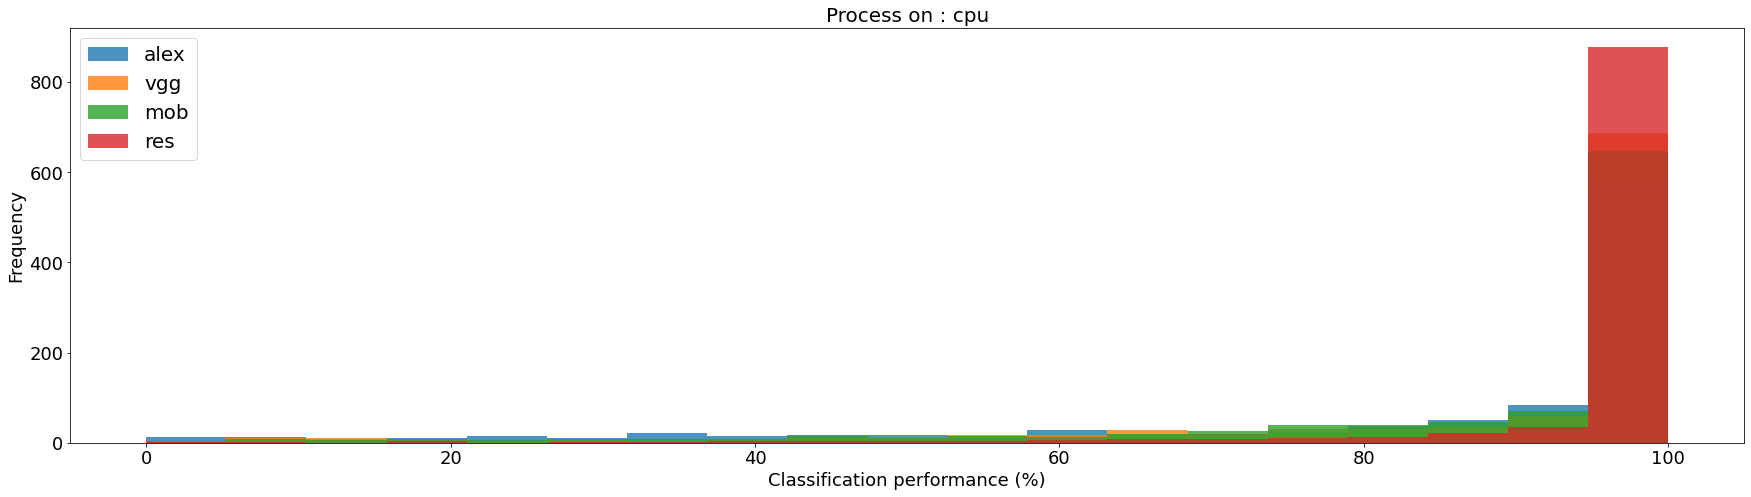

In [15]:
fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, name in zip(colors, models.keys()):
    axs.set_ylabel('Frequency', size= 18)
    axs.set_xlabel('Classification performance (%)', size= 18)
    df[df['model']==name]['perf'].plot.hist(bins=np.linspace(0, 100, 20), lw=0, alpha=0.8, label=name)
    axs.legend(loc=0, fontsize = 20)
    axs.set_title('Process on : ' + str(df['device'][0]), size = 20)

Here we display the 64 worsts classification performance, all model combined : 

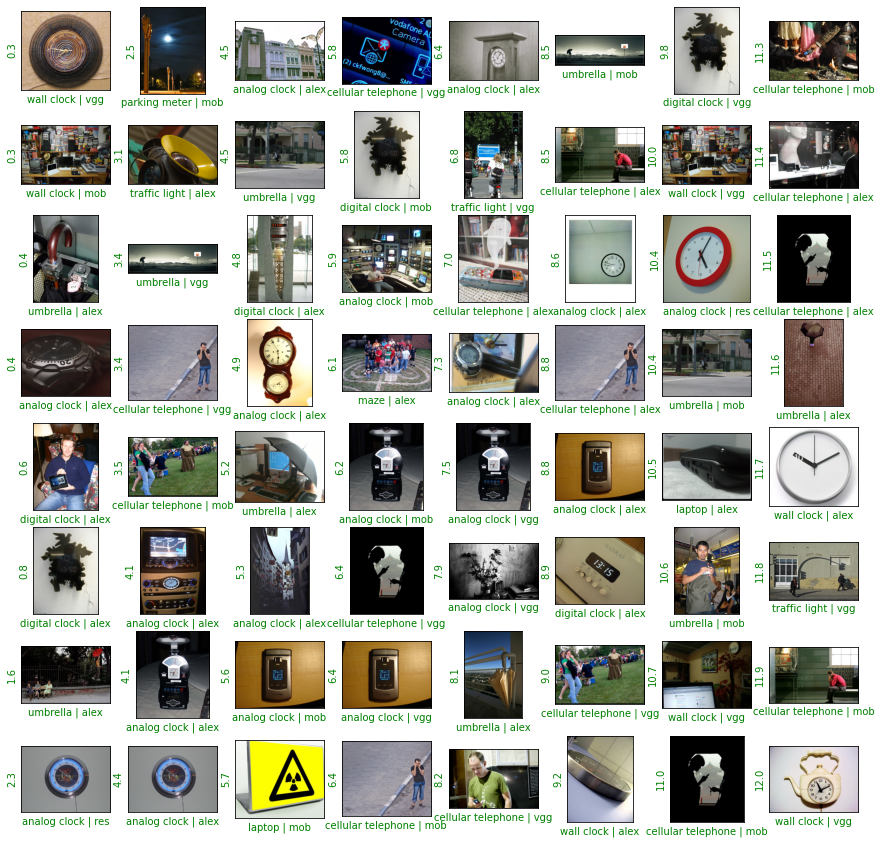

In [16]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(15, 15))
for i, idx in enumerate(df["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_dataset.imgs[df.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df.loc[idx]['label'] + ' | ' + df.loc[idx]['model'], color='g')
    perf_ = df.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')    

A display of the differents compuation time of each models on the same dataset for a single resolution :

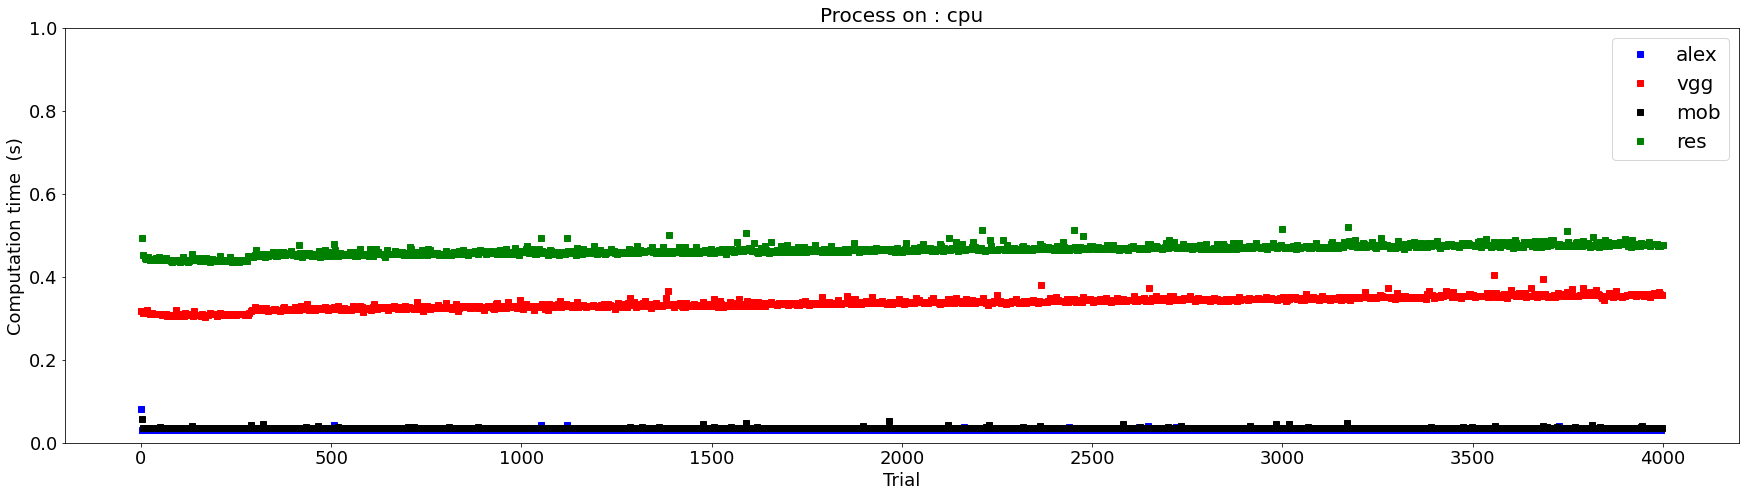

In [17]:
fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

for color, name in zip(colors, models.keys()):
    axs.set_ylabel('Computation time  (s)', size= 18)
    axs.set_xlabel('Trial', size= 18)
    axs.set_ylim(0, 1)
    df[df['model']==name]['time'].plot(label=name, color=color, marker='s', lw=0)
    axs.legend(loc=0, fontsize = 20)
    axs.set_title('Process on : ' + str(df['device'][0]), size = 20)

To make it even clearer we extracted a specific median for each models : 

Accuracy's median

In [18]:
for name in models.keys():
    med_perf = np.median(df[df['model']==name]["perf"])
    print(f'For the {name} model, the median clasification performance =  {med_perf:.1f} %' )

For the alex model, the median clasification performance =  98.1 %
For the vgg model, the median clasification performance =  99.5 %
For the mob model, the median clasification performance =  99.2 %
For the res model, the median clasification performance =  100.0 %


Computation time 's median

In [19]:
for name in models.keys():
    med_perf = np.median(df[df['model']==name]["time"])
    print(f'For the {name} model, the median computation time  =  {med_perf:.3f} s')

For the alex model, the median computation time  =  0.032 s
For the vgg model, the median computation time  =  0.338 s
For the mob model, the median computation time  =  0.035 s
For the res model, the median computation time  =  0.466 s


Frame per second's median

In [20]:
for name in models.keys():
    med_perf = np.median(df[df['model']==name]["fps"])
    print(f'For the {name} model, the median fps  =  {med_perf:.3f} Hz' )

For the alex model, the median fps  =  31.512 Hz
For the vgg model, the median fps  =  2.957 Hz
For the mob model, the median fps  =  28.433 Hz
For the res model, the median fps  =  2.146 Hz


The model wih seems to present the best accuracy is the `Resnet_101` network, the cost for a high accuracy is represented in the computation time  the network need to compute an image so the Resnet_101 also present the higher computation time. Note that the Mobilenet network show a good accuracy (>80%) while it keeps a reasonable computation's time which come with a high frame per second rate that allows real time recognition. 

# Experiment 2: Image processing and recognition for differents resolutions :

In [21]:
scriptname = 'experiment_downsample.py'

In [22]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_benchmark.models import *
filename = f'results/{datetag}_results_2_{HOST}.json'

# Output's set up
try:
    df_downsample = pd.read_json(filename)
except:
    df_downsample = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'image_size', 'filename', 'device']) 
    i_trial = 0

    # image preprocessing
    for image_size in image_sizes:
        image_size = int(image_size)
        transform = transforms.Compose([  # Downsampling function on the input
        transforms.Resize(image_size),      #  Resize the image to image_size x image_size pixels size.
        transforms.CenterCrop(image_size),  # Crop the image to image_size x image_size pixels around the center.
        transforms.ToTensor(),       # Convert the image to PyTorch Tensor data type.
        transforms.Normalize(        # Normalize the image by adjusting its average and
                                     # its standard deviation at the specified values.
        mean=[0.485, 0.456, 0.406],                
        std=[0.229, 0.224, 0.225]                  
        )])
        image_dataset_downsample = ImageFolder(path, transform=transform) # Get the downsample dataset
        print(f'Résolution de {image_size}')
        # Displays the input image of the model 
        for i_image, (data, label) in enumerate(image_dataset_downsample):
            for name in models.keys():
                model = models[name]
                model.eval()
                tic = time.time()
                out = model(data.unsqueeze(0).to(device)).squeeze(0)
                percentage = torch.nn.functional.softmax(out[i_labels], dim=0) * 100
                _, indices = torch.sort(percentage, descending=True)           
                dt = time.time() - tic
                i_label_top = reverse_labels[image_dataset_downsample.classes[label]]
                perf_ = percentage[reverse_i_labels[i_label_top]].item()            
                df_downsample.loc[i_trial] = {'model':name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_dataset.imgs[i_image][0], 'image_size': image_size, 'device':str(device)}
                print(f'The {name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds')
                i_trial += 1
        df_downsample.to_json(filename)

Overwriting experiment_downsample.py


In [23]:
if do_local:
    %run {scriptname}
else:
    !{python_exec} {scriptname}

<Figure size 432x288 with 0 Axes>

## Image recognition on differents resolutions display :

Here, again, we collect our results, and display all the data in a table 

In [24]:
filename = f'results/{datetag}_results_2_{HOST}.json'
df_downsample = pd.read_json(filename)
df_downsample

,model,perf,fps,time,label,i_label,i_image,image_size,filename,device
0,alex,3.081075,41.662237,0.024003,analog clock,409,0,64,data/imagenet_classes_100/analog clock/1036540...,cpu
1,vgg,69.224487,13.435832,0.074428,analog clock,409,0,64,data/imagenet_classes_100/analog clock/1036540...,cpu
2,mob,24.449986,46.564057,0.021476,analog clock,409,0,64,data/imagenet_classes_100/analog clock/1036540...,cpu
3,res,99.957542,6.375514,0.156850,analog clock,409,0,64,data/imagenet_classes_100/analog clock/1036540...,cpu
4,alex,7.803873,47.921759,0.020867,analog clock,409,1,64,data/imagenet_classes_100/analog clock/1067793...,cpu
...,...,...,...,...,...,...,...,...,...,...
15995,res,73.330154,0.479890,2.083810,wall clock,892,998,512,data/imagenet_classes_100/wall clock/944534279...,cpu
15996,alex,66.193993,11.489796,0.087034,wall clock,892,999,512,data/imagenet_classes_100/wall clock/97880360_...,cpu
15997,vgg,49.747814,0.703728,1.421005,wall clock,892,999,512,data/imagenet_classes_100/wall clock/97880360_...,cpu
15998,mob,43.013065,5.839347,0.171252,wall clock,892,999,512,data/imagenet_classes_100/wall clock/97880360_...,cpu


A display of the accuracy of each models on the same dataset for differents resolutions :

Here accuracies are displayed as a violin plot to allow a better representation of the models.

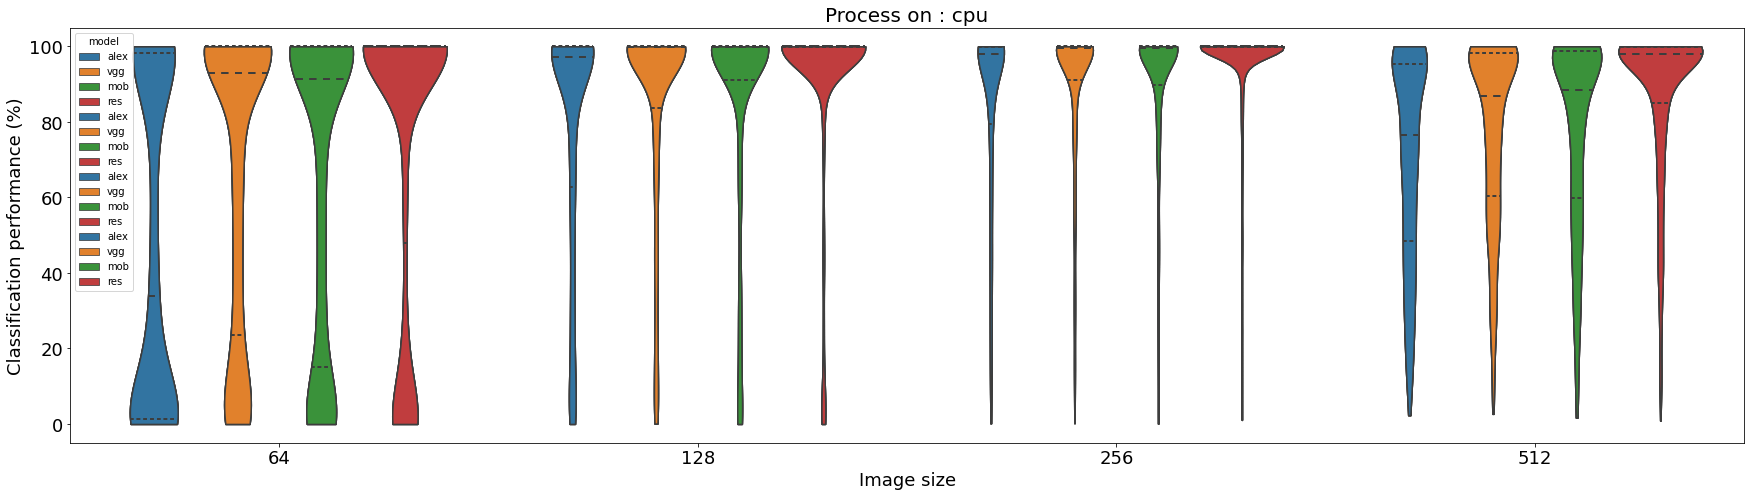

In [25]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, name in zip(colors, models.keys()):
    axs = sns.violinplot(x="image_size", y="perf", data=df_downsample, inner="quartile", hue='model',cut = 0)
    axs.set_title('Process on : ' + str(df_downsample['device'][0]), size=20)
    axs.set_ylabel('Classification performance (%)', size=18)
    axs.set_xlabel('Image size', size=18)

The 64 worsts classification performance, all model combined : 

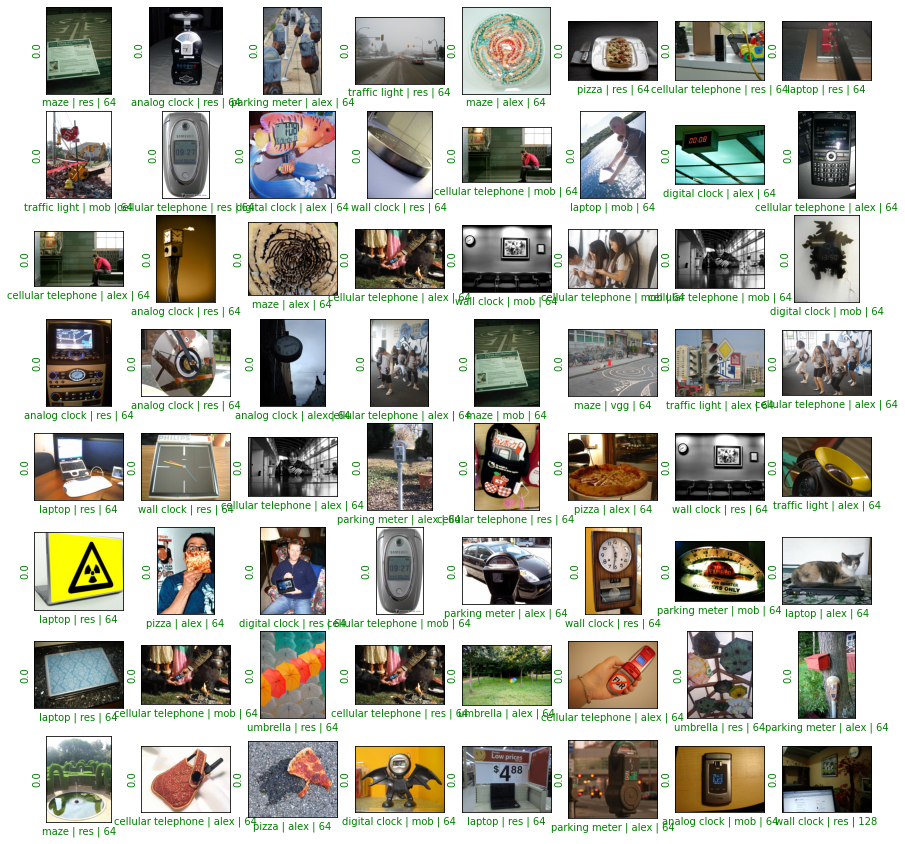

In [26]:
N_image_i = 8
N_image_j = 8
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(15, 15))
for i, idx in enumerate(df_downsample["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_dataset.imgs[df_downsample.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_downsample.loc[idx]['label'] + ' | ' + df_downsample.loc[idx]['model']+ ' | ' + str(df_downsample.loc[idx]['image_size']), color='g')
    perf_ = df_downsample.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')    

A display of the differents compuation time of each models on the same dataset for differents resolutions :

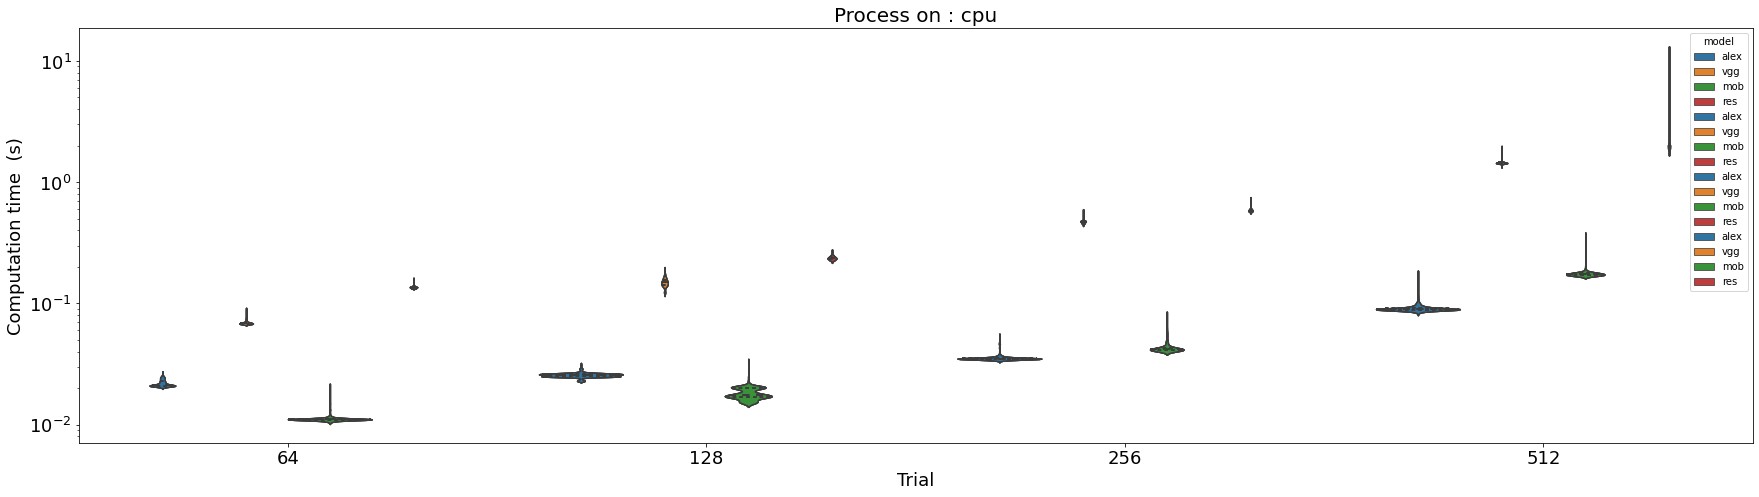

In [27]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, name in zip(colors, models.keys()):
    axs = sns.violinplot(x="image_size", y="time", data=df_downsample, inner="quartile", hue='model')
    axs.set_title('Process on : ' + str(df_downsample['device'][0]), size = 20)
    axs.set_ylabel('Computation time  (s)', size= 18)
    axs.set_xlabel('Trial', size= 18)
    axs.set_yscale('log')

Again, we extracted a specific median for each models : 

In [28]:
for name in models.keys():
    med_perf = np.median(df_downsample[df_downsample['model']==name]["perf"])
    print(f'For the {name} model, the median clasification performance =  {med_perf:.3f} %' )

For the alex model, the median clasification performance =  88.975 %
For the vgg model, the median clasification performance =  97.585 %
For the mob model, the median clasification performance =  98.090 %
For the res model, the median clasification performance =  99.985 %


The classification performance does not depend on the host (a priori :-) ) but the timing does:

In [29]:
for name in models.keys():
    med_perf = np.median(df_downsample[df_downsample['model']==name]["time"])
    print(f'For the {name} model, the median  computation time =  {med_perf:.2f} s' )

For the alex model, the median  computation time =  0.03 s
For the vgg model, the median  computation time =  0.32 s
For the mob model, the median  computation time =  0.04 s
For the res model, the median  computation time =  0.42 s


In [30]:
for name in models.keys():
    med_perf = np.median(df_downsample[df_downsample['model']==name]["fps"])
    print(f'For the {name} model, the median fps  =  {med_perf:.3f} Hz' )

For the alex model, the median fps  =  30.586 Hz
For the vgg model, the median fps  =  3.721 Hz
For the mob model, the median fps  =  27.222 Hz
For the res model, the median fps  =  2.712 Hz


The performance seems reduce when the resolution is to low or to high as the regular size of an input's image is around 256 x 256 pixels. Also, the computation time  seems proportional to the resolution, a higher resolution need a higher delay to compute the image on a CPU. 

# Experiment 3: Image processing and recognition on Grayscale :

In [31]:
scriptname = 'experiment_grayscale.py'

In [32]:
%%writefile {scriptname}

#import model's script and set the output file
from DCNN_benchmark.models import *
filename = f'results/{datetag}_results_3_{HOST}.json'

# Output's set up
try:
    df_gray = pd.read_json(filename)
except:
    df_gray = pd.DataFrame([], columns=['model', 'perf', 'fps', 'time', 'label', 'i_label', 'i_image', 'filename', 'device']) 
    i_trial = 0
    
    # image preprocessing
    transform = transforms.Compose([
    transforms.Grayscale(3),      # convert the image in grayscale
    transforms.Resize(int(image_size)),      # Resize the image.
    transforms.CenterCrop(int(image_size-20)), # Crop the image with a 20 pixels border.
    transforms.ToTensor(),       # Convert the image to PyTorch Tensor data type.
    transforms.Normalize(        # Normalize the image by adjusting its average and
                                 #     its standard deviation at the specified values.
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
    )])
    image_dataset_grayscale = ImageFolder(path, transform=transform) # Get the downsample dataset

    # Displays the input image of the model
    for i_image, (data, label) in enumerate(image_dataset_grayscale):
            for name in models.keys():
                model = models[name]
                model.eval()
                tic = time.time()
                out = model(data.unsqueeze(0).to(device)).squeeze(0)
                percentage = torch.nn.functional.softmax(out[i_labels], dim=0) * 100
                _, indices = torch.sort(percentage, descending=True)           
                dt = time.time() - tic
                i_label_top = reverse_labels[image_dataset_grayscale.classes[label]]
                perf_ = percentage[reverse_i_labels[i_label_top]].item()            
                df_gray.loc[i_trial] = {'model':name, 'perf':perf_, 'time':dt, 'fps': 1/dt,
                                   'label':labels[i_label_top], 'i_label':i_label_top, 
                                   'i_image':i_image, 'filename':image_dataset.imgs[i_image][0], 'device':str(device)}
                print(f'The {name} model get {labels[i_label_top]} at {perf_:.2f} % confidence in {dt:.3f} seconds')
                i_trial += 1
    df_gray.to_json(filename)

Overwriting experiment_grayscale.py


In [33]:
if do_local:
    %run {scriptname}
else:
    !{python_exec} {scriptname}

<Figure size 432x288 with 0 Axes>

## Image recognition on differents labels with grayscale display :

Collecting all the results, displaying all the data in a table 

In [34]:
filename = f'results/{datetag}_results_3_{HOST}.json'
df_gray = pd.read_json(filename)
df_gray

,model,perf,fps,time,label,i_label,i_image,filename,device
0,alex,30.689531,12.114633,0.082545,analog clock,409,0,data/imagenet_classes_100/analog clock/1036540...,cpu
1,vgg,76.106209,3.074683,0.325237,analog clock,409,0,data/imagenet_classes_100/analog clock/1036540...,cpu
2,mob,84.234848,17.334843,0.057687,analog clock,409,0,data/imagenet_classes_100/analog clock/1036540...,cpu
3,res,42.538277,2.000815,0.499796,analog clock,409,0,data/imagenet_classes_100/analog clock/1036540...,cpu
4,alex,1.149381,31.363269,0.031884,analog clock,409,1,data/imagenet_classes_100/analog clock/1067793...,cpu
...,...,...,...,...,...,...,...,...,...
3995,res,84.015839,2.196415,0.455287,wall clock,892,998,data/imagenet_classes_100/wall clock/944534279...,cpu
3996,alex,59.561806,31.358813,0.031889,wall clock,892,999,data/imagenet_classes_100/wall clock/97880360_...,cpu
3997,vgg,66.367882,3.203566,0.312152,wall clock,892,999,data/imagenet_classes_100/wall clock/97880360_...,cpu
3998,mob,47.893391,28.080150,0.035612,wall clock,892,999,data/imagenet_classes_100/wall clock/97880360_...,cpu


A display of the accuracy of each models on the same dataset for a single resolution :

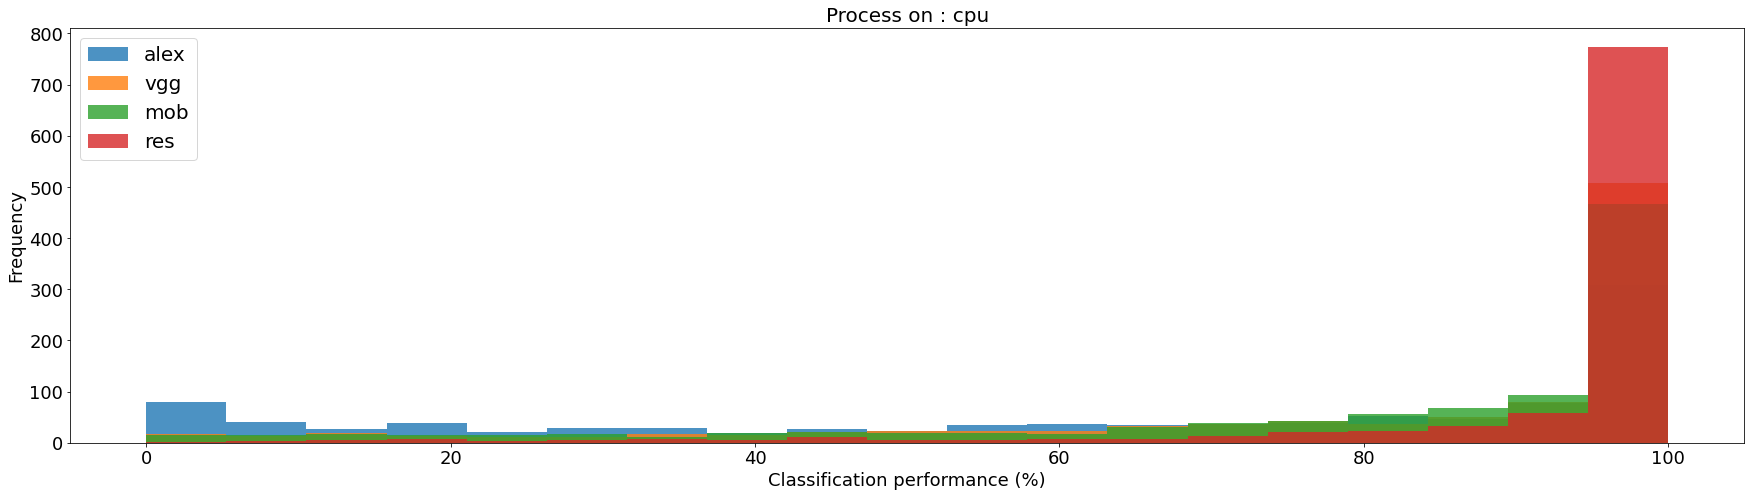

In [35]:
fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, name in zip(colors, models.keys()):
    axs.set_ylabel('Frequency', size= 18)
    axs.set_xlabel('Classification performance (%)', size= 18)
    df_gray[df_gray['model']==name]['perf'].plot.hist(bins=np.linspace(0, 100, 20), lw=0, alpha=0.8, label=name)
    axs.legend(loc=0, fontsize = 20)
    axs.set_title('Process on : ' + str(df_gray['device'][0]), size = 20)

The 64 worsts classification performance, all model combined : 

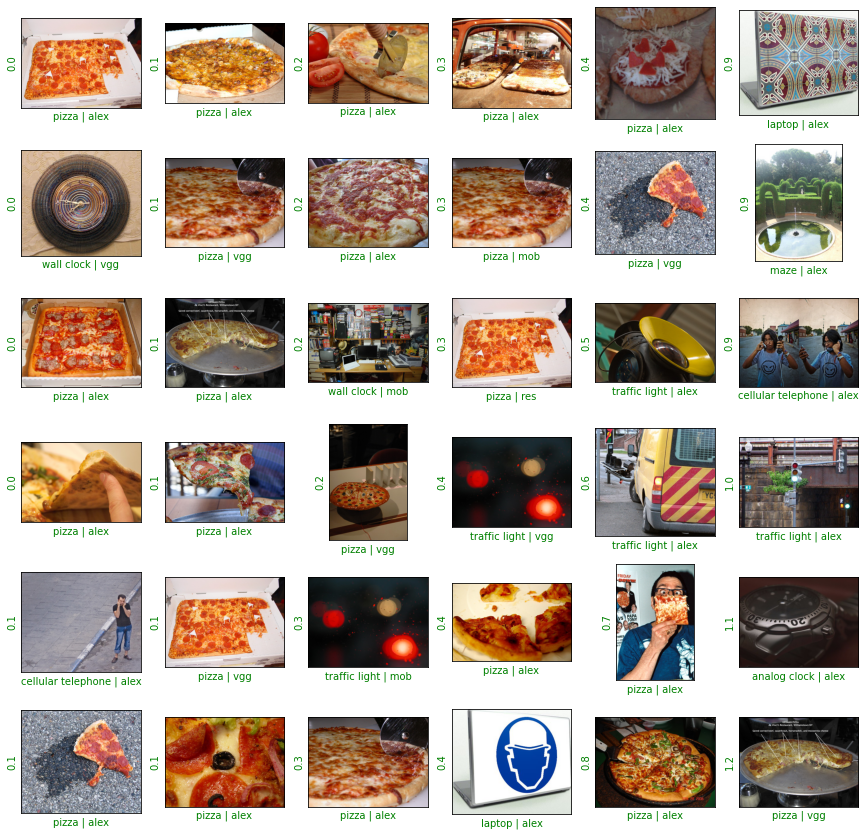

In [36]:
N_image_i = 6
N_image_j = 6
fig, axs = plt.subplots(N_image_i, N_image_j, figsize=(15, 15))
for i, idx in enumerate(df_gray["perf"].argsort()[:(N_image_i*N_image_j)]):
    ax = axs[i%N_image_i][i//N_image_i]
    ax.imshow(imageio.imread(image_dataset.imgs[df_gray.loc[idx]['i_image']][0]))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(df_gray.loc[idx]['label'] + ' | ' + df_gray.loc[idx]['model'], color='g')
    perf_ = df_gray.loc[idx]['perf']
    ax.set_ylabel(f'{perf_:2.1f}', color='g')    

A display of the differents computation time of each models on the same dataset for a single resolution :

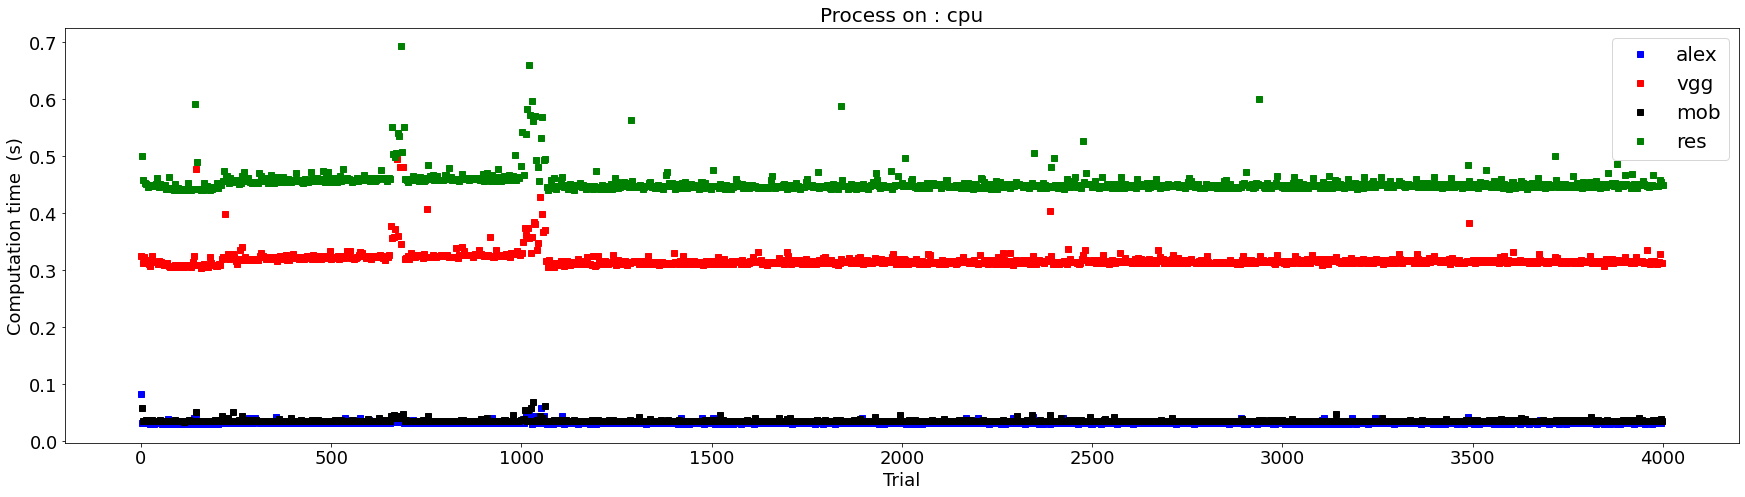

In [37]:
fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

for color, name in zip(colors, models.keys()):
    axs.set_ylabel('Computation time  (s)', size= 18)
    axs.set_xlabel('Trial', size= 18)
    df_gray[df_gray['model']==name]['time'].plot(label=name, color=color, marker='s', lw=0)
    axs.legend(loc=0, fontsize = 20)
    axs.set_title('Process on : ' + str(df_gray['device'][0]), size = 20)

Extracted a specific median for each models

In [38]:
for name in models.keys():
    med_perf = np.median(df_gray[df_gray['model']==name]["perf"])
    print(f'For the {name} model, the median clasification performance =  {med_perf:.1f} %' )

For the alex model, the median clasification performance =  76.6 %
For the vgg model, the median clasification performance =  95.0 %
For the mob model, the median clasification performance =  93.4 %
For the res model, the median clasification performance =  100.0 %


In [39]:
for name in models.keys():
    med_perf = np.median(df_gray[df_gray['model']==name]["time"])
    print(f'For the {name} model, the median computation time  =  {med_perf:.3f} s' )

For the alex model, the median computation time  =  0.032 s
For the vgg model, the median computation time  =  0.316 s
For the mob model, the median computation time  =  0.036 s
For the res model, the median computation time  =  0.449 s


In [40]:
for name in models.keys():
    med_perf = np.median(df_gray[df_gray['model']==name]["fps"])
    print(f'For the {name} model, the median fps  =  {med_perf:.3f} Hz' )

For the alex model, the median fps  =  31.615 Hz
For the vgg model, the median fps  =  3.168 Hz
For the mob model, the median fps  =  28.153 Hz
For the res model, the median fps  =  2.225 Hz


The grayscale transformation on the input seems to degrade the recognition for all the models as they perform on the same dataset.

A display of the accuracy of each models on the same dataset for differents resolutions :

Here accuracies are displayed as a violin plot to allow a better representation of the models.

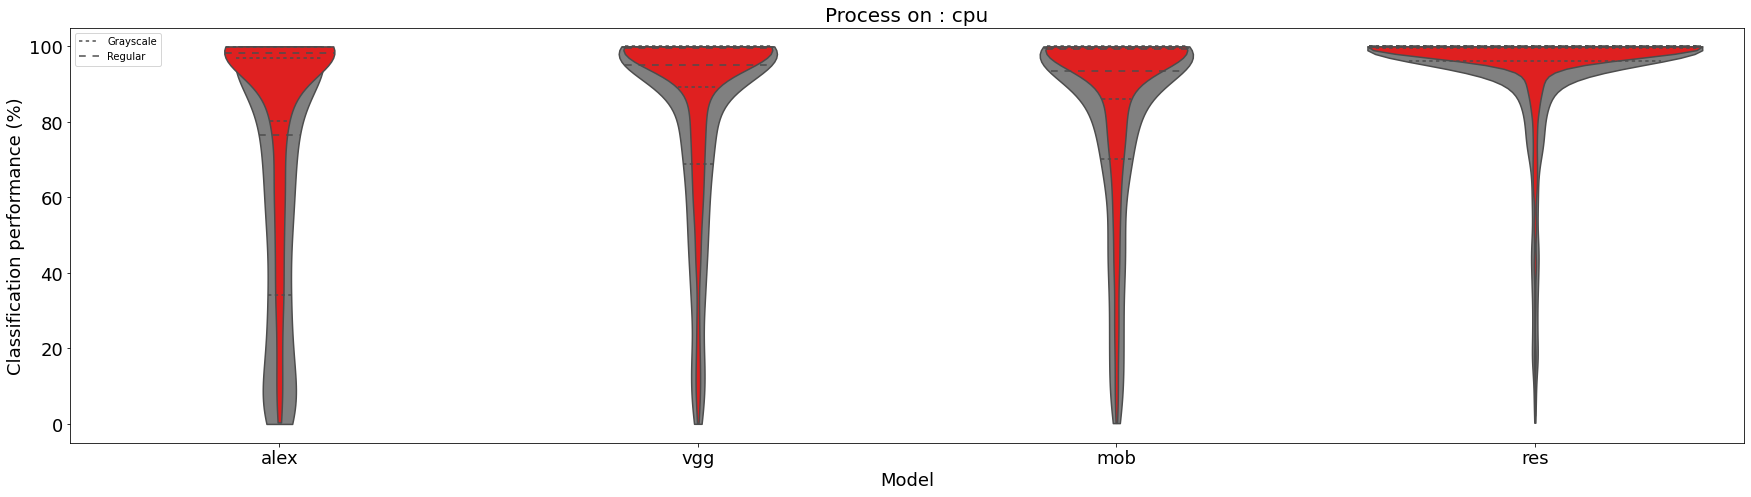

In [41]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(30, fig_width/phi))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
for color, df_, label in zip(['gray', 'red'], [df_gray, df], ['black', 'color']):
    axs = sns.violinplot(x="model", y="perf", data=df_, inner="quartile", cut=0, color=color, alpha=.5)
    axs.set_title('Process on : ' + str(df_['device'][0]), size=20)
    axs.set_ylabel('Classification performance (%)', size=18)
    axs.legend(['Grayscale', 'Regular'])
    axs.set_xlabel('Model', size=18)

# Final synthesis

We have run the benchmark on various platforms, with or without GPU. Let's summarize the main message.


In [42]:
HOSTS = {'fortytwo':'iMac pro 36 cores', 
         'ai-int-desktop': 'NVIDIA Jetson TX2',
         'jnjer-HP-Pavilion-Notebook' : 'Intel core i5 7th gen'
        # 'inv-ope-de06': 'Dell station with GTX Tegra',
        }
for HOST in  HOSTS:
    print('HOST:', HOST, ', device:', HOSTS[HOST])

HOST: fortytwo , device: iMac pro 36 cores
HOST: ai-int-desktop , device: NVIDIA Jetson TX2
HOST: jnjer-HP-Pavilion-Notebook , device: Intel core i5 7th gen


We verify that the classification performance is similar on different machines (as these algorithms are deterministic):

In [43]:
for i in [1,3]:
    for HOST in HOSTS:
        filename = f'results/{datetag}_results_{i}_{HOST}.json'
        print(filename)
        df = pd.read_json(filename)
        for name in models.keys():
            med_perf = np.median(df[df['model']==name]["perf"])
            print(f'On host {HOSTS[HOST]}, for the {name} model, the median clasification performance =  {med_perf:.3f} %' )

results/2020-08-27_results_1_fortytwo.json
On host iMac pro 36 cores, for the alex model, the median clasification performance =  95.597 %
On host iMac pro 36 cores, for the vgg model, the median clasification performance =  97.133 %
On host iMac pro 36 cores, for the mob model, the median clasification performance =  96.411 %
On host iMac pro 36 cores, for the res model, the median clasification performance =  99.971 %
results/2020-08-27_results_1_ai-int-desktop.json
On host NVIDIA Jetson TX2, for the alex model, the median clasification performance =  98.554 %
On host NVIDIA Jetson TX2, for the vgg model, the median clasification performance =  99.647 %
On host NVIDIA Jetson TX2, for the mob model, the median clasification performance =  99.376 %
On host NVIDIA Jetson TX2, for the res model, the median clasification performance =  99.998 %
results/2020-08-27_results_1_jnjer-HP-Pavilion-Notebook.json
On host Intel core i5 7th gen, for the alex model, the median clasification performan

But that the computation time varies greatly depending on the platform:

In [44]:
for i in [1,3]:
    for HOST in HOSTS:
        filename = f'results/{datetag}_results_{i}_{HOST}.json'
        print(filename)
        df = pd.read_json(filename)
        for name in models.keys():
            med_perf = np.median(df[df['model']==name]["time"])
            print(f'On host {HOSTS[HOST]}, for the {name} model, the median computation time  =  {med_perf:.3f} s' )

results/2020-08-27_results_1_fortytwo.json
On host iMac pro 36 cores, for the alex model, the median computation time  =  0.086 s
On host iMac pro 36 cores, for the vgg model, the median computation time  =  0.420 s
On host iMac pro 36 cores, for the mob model, the median computation time  =  0.062 s
On host iMac pro 36 cores, for the res model, the median computation time  =  0.609 s
results/2020-08-27_results_1_ai-int-desktop.json
On host NVIDIA Jetson TX2, for the alex model, the median computation time  =  0.024 s
On host NVIDIA Jetson TX2, for the vgg model, the median computation time  =  0.101 s
On host NVIDIA Jetson TX2, for the mob model, the median computation time  =  0.072 s
On host NVIDIA Jetson TX2, for the res model, the median computation time  =  0.307 s
results/2020-08-27_results_1_jnjer-HP-Pavilion-Notebook.json
On host Intel core i5 7th gen, for the alex model, the median computation time  =  0.032 s
On host Intel core i5 7th gen, for the vgg model, the median compu

From experiment 2, we check on the different hosts the same trend of classification performance for different image size :

In [45]:
for HOST in HOSTS:
    filename = f'results/{datetag}_results_2_{HOST}.json'
    df = pd.read_json(filename)
    for size in image_sizes :
        print(f'Image size : {size}')
        for name in models.keys():
            med_perf = np.median(df[df['model']==name][df['image_size']==size]["perf"])
            print(f'On host {HOSTS[HOST]}, for the {name} model, the median clasification performance =  {med_perf:.3f} %' )

Image size : 64
On host iMac pro 36 cores, for the alex model, the median clasification performance =  14.781 %
On host iMac pro 36 cores, for the vgg model, the median clasification performance =  77.834 %
On host iMac pro 36 cores, for the mob model, the median clasification performance =  70.676 %
On host iMac pro 36 cores, for the res model, the median clasification performance =  99.863 %
Image size : 128
On host iMac pro 36 cores, for the alex model, the median clasification performance =  91.608 %
On host iMac pro 36 cores, for the vgg model, the median clasification performance =  98.264 %
On host iMac pro 36 cores, for the mob model, the median clasification performance =  98.922 %
On host iMac pro 36 cores, for the res model, the median clasification performance =  99.999 %
Image size : 256
On host iMac pro 36 cores, for the alex model, the median clasification performance =  94.342 %
On host iMac pro 36 cores, for the vgg model, the median clasification performance =  97.380

/home/jnjer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


On host NVIDIA Jetson TX2, for the res model, the median clasification performance =  0.000 %
Image size : 128
On host NVIDIA Jetson TX2, for the alex model, the median clasification performance =  97.554 %
On host NVIDIA Jetson TX2, for the vgg model, the median clasification performance =  99.914 %
On host NVIDIA Jetson TX2, for the mob model, the median clasification performance =  99.964 %
On host NVIDIA Jetson TX2, for the res model, the median clasification performance =  100.000 %
Image size : 256
On host NVIDIA Jetson TX2, for the alex model, the median clasification performance =  98.404 %
On host NVIDIA Jetson TX2, for the vgg model, the median clasification performance =  99.761 %
On host NVIDIA Jetson TX2, for the mob model, the median clasification performance =  99.768 %
On host NVIDIA Jetson TX2, for the res model, the median clasification performance =  99.999 %
Image size : 512
On host NVIDIA Jetson TX2, for the alex model, the median clasification performance =  77.38

Performance may differ due to differences between datasets.